importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

reading the data

In [2]:
data = pd.read_csv('/Users/aalaaseif/Documents/ITI/Machine Learning 2/Lab/Clustering_gmm .csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  500 non-null    float64
 1   Height  500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [4]:
data

,Weight,Height
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679
...,...,...
495,59.976983,169.679741
496,66.423814,174.625574
497,53.604698,161.919208
498,50.433644,160.794875


Visualization

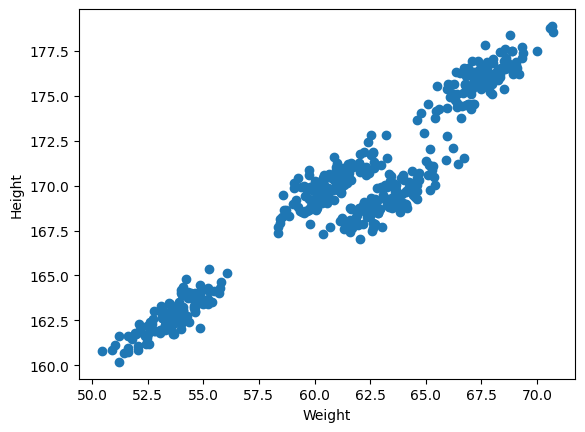

In [5]:
plt.scatter(data['Weight'], data['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

<Axes: >

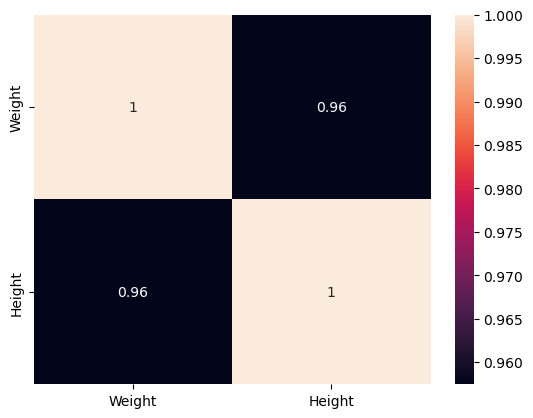

In [6]:
sns.heatmap(data.corr(), annot=True)

array([[<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Height'}>]], dtype=object)

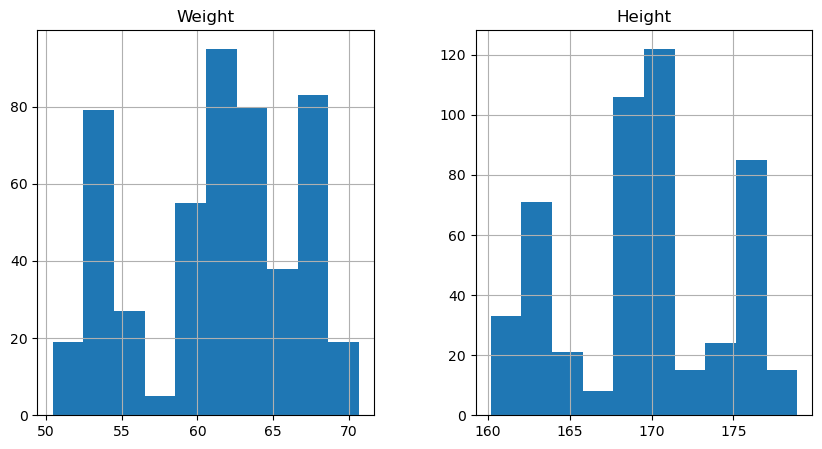

In [7]:
data.hist(figsize=(10, 5))

<Axes: >

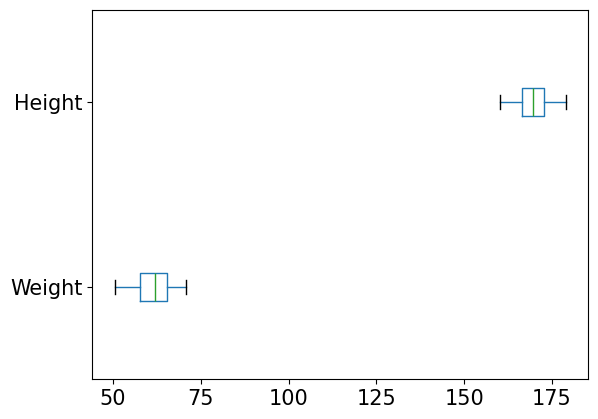

In [8]:
data.boxplot(grid=False, vert=False, fontsize=15)

Standrize the data

In [9]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# K-Means

In [10]:
class CustomKMeans:
    
    def __init__(self, num_clusters=2, tolerance=0.001, max_iterations=500):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.tolerance = tolerance
    
    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2)
        
    def predict(self, data_point):
        distances = [np.linalg.norm(data_point - centroid) for centroid in self.cluster_centers.values()]
        return np.argmin(distances)
    
    def fit(self, dataset):
        self.cluster_centers = {i: dataset[i] for i in range(self.num_clusters)}
        
        for iteration in range(self.max_iterations):
            self.cluster_assignments = {j: [] for j in range(self.num_clusters)}
                
            for sample in dataset:
                distances = [self.euclidean_distance(sample, centroid) for centroid in self.cluster_centers.values()]
                cluster_idx = np.argmin(distances)
                self.cluster_assignments[cluster_idx].append(sample)
            
            previous_centers = np.array(list(self.cluster_centers.values()))
            for cluster_idx in self.cluster_assignments:
                if self.cluster_assignments[cluster_idx]:  
                    self.cluster_centers[cluster_idx] = np.mean(self.cluster_assignments[cluster_idx], axis=0)
            
            new_centers = np.array(list(self.cluster_centers.values()))
            if np.linalg.norm(new_centers - previous_centers) < self.tolerance:
                print(f"Converged at iteration {iteration}")
                break

In [11]:
num_clusters = 4
kmeans_model = CustomKMeans(num_clusters)
kmeans_model.fit(data_scaled)

Converged at iteration 27


In [12]:
cluster_labels = np.array([kmeans_model.predict(sample) for sample in data_scaled])

In [13]:
silhouette = silhouette_score(data_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.595065322092602


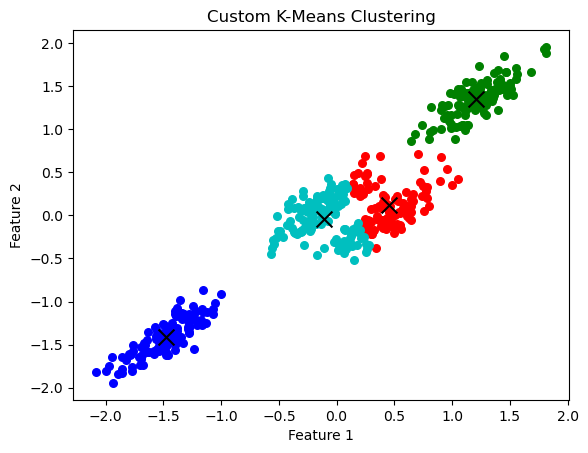

In [14]:
colors = ["r", "g", "c", "b"]

for cluster_idx, points in kmeans_model.cluster_assignments.items():
    color = colors[cluster_idx % len(colors)]
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], color=color, s=30)

for centroid in kmeans_model.cluster_centers.values():
    plt.scatter(centroid[0], centroid[1], s=130, marker="x", color="black")

plt.title('Custom K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Gaussian Mixture Model

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [16]:
n_samples = 300
n_features = 2
n_clusters = 4
random_state = 42

In [17]:
def gmm(X, k, max_iters=100):
    num_samples, num_features = X.shape
    centroids = X[np.random.choice(num_samples, k, replace=False)]
    cov_matrices = [np.eye(num_features)] * k
    weights = np.ones(k) / k
    tol = 1e-4  
    prev_val = 0 
    converged_iter = 0 
    
    for i in range(max_iters):
        responsibilities = []
        for j in range(k):
            prob = multivariate_normal.pdf(X, mean=centroids[j], cov=cov_matrices[j]) * weights[j]
            responsibilities.append(prob)
        responsibilities = np.array(responsibilities).T
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        total_resp = np.sum(responsibilities, axis=0)
        weights = total_resp / num_samples
        centroids = (responsibilities.T @ X) / total_resp[:, np.newaxis]
        
        for j in range(k):
            diff = X - centroids[j]
            cov_matrices[j] = ((responsibilities[:, j] * diff.T) @ diff) / total_resp[j]
        
        if np.linalg.norm(prob - prev_val) < tol:
            converged_iter = i
            break  
        
        prev_val = prob  
    
    return centroids, cov_matrices, weights, converged_iter

In [18]:
gmm_centroids, gmm_covs, gmm_weights, converged_iter = gmm(data_scaled, n_clusters)

In [19]:
def assign_clusters(X, centroids, cov_matrices, weights):
    num_samples = X.shape[0]
    k = len(centroids)
    responsibilities = np.zeros((num_samples, k))
    
    for j in range(k):
        responsibilities[:, j] = multivariate_normal.pdf(X, mean=centroids[j], cov=cov_matrices[j]) * weights[j]
    
    return np.argmax(responsibilities, axis=1)

In [20]:
cluster_labels = assign_clusters(data_scaled, gmm_centroids, gmm_covs, gmm_weights)

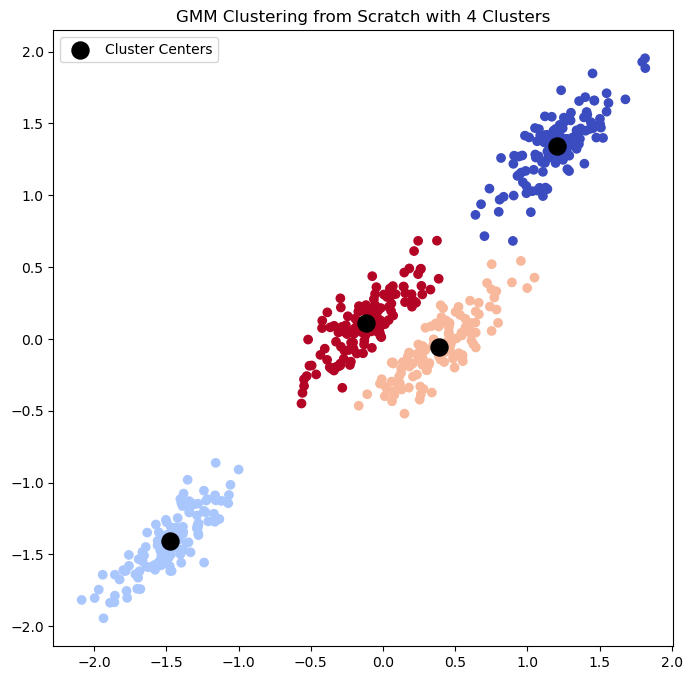

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=cluster_labels, cmap='coolwarm')
plt.scatter(gmm_centroids[:, 0], gmm_centroids[:, 1], marker='o', s=150, color='black', label='Cluster Centers')
plt.legend()
plt.title(f'GMM Clustering from Scratch with {n_clusters} Clusters')
plt.show()